<a href="https://colab.research.google.com/github/cathemesquita/Colab_notebooks/blob/main/CRIANDO_DF_COM_O_DADO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install open-ephys-python-tools

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.6/380.6 kB 11.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for open-ephys-python-tools: filename=open_ephys_python_tools-0.1.4-py3-none-any.whl size=38789 sha256=1c93eb4f80eb54975d3c31afc2ef1a360752abd887a5f9967ac8abf6fe47cc56
  Stored in directory: /root/.cache/pip/wheels/41/31/b0/98896ac5a95a729ddd3ec0e315d3d67a0396b9a586b4616adb
  Created wheel for zmq: filename=zmq-0.0.0-py3-none-any.whl size=1264 sha256=ce00f13cbd6823d4df417992424f1d0914ff59f2ef2016b95d0d06bbe74cdd40
  Stored in directory: /root/.cache/pip/wheels/ab/c5/fe/d853f71843cae26c123d37a7a5934baac20fc66f35a913951d
Successfully built open-ephys-python-tools zmq


In [ ]:
from open_ephys.analysis import Session

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import scipy as sp
from scipy import signal
import math
from scipy.signal import welch, spectrogram, coherence, find_peaks, firwin, lfilter, filtfilt
import seaborn as sn
import scipy.signal as sig

import math
import time as ttime
from numpy.fft import fft, ifft, rfft, fftfreq
from scipy.signal import firwin, lfilter, filtfilt
from scipy.io import loadmat


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## MAPEAMENTO DOS CH DE ACORDO COM IMUNO
# CCM 497
* IL --> ch 1-8
* PRL --> ch 25-32
* CG 2 --> ch 17-24
* CG 1 --> ch 9-16

# CCM 559
* IL --> ficou fora!
* PRL --> ch 25-32 e ch 9-16
* CG 2 --> não pegou
* CG1 --> ch 17-24


> # CCM 497
Canais de interesse: PRL --> ch 25-32, CG 1 --> ch 9-16

In [ ]:
OF_pre_497 = '/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pré-screening/CCM497'
OF_pos_497 = '/content/drive/Shareddrives/Registros open ephys Desamparo/Registros desamparo open ephys/Experimento Ephys/Dia 2 - Screening 16 12 22/OF pós-screening/CCM497'

session1_497 = Session(OF_pre_497)
session2_497 = Session(OF_pos_497)

In [ ]:
# OF_pre
rn1 = session1_497.recordnodes[0].recordings[0] #selecionando o record node desejado

# OF_pos
rn2 = session2_497.recordnodes[0].recordings[0] #selecionando o record node desejado



# Ajustando o vetor de timestamps para iniciar em zero e ter o mesmo tamanho do dado
t_raw1= rn1.continuous[0].timestamps
t1 = t_raw1-t_raw1[0]

t_raw2= rn2.continuous[0].timestamps
t2 = t_raw2-t_raw2[0]

# EXTRAINDO OS DADOS
data_pre = rn1.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t1))
data_pos = rn2.continuous[0].get_samples(start_sample_index=0, end_sample_index=len(t2))

In [ ]:

window = signal.windows.hamming(1000)




#filtros das faixas de freq
filt_delta = firwin(101, [0.5,4], pass_zero='bandpass', window='hamming',  fs=1000)
filt_theta = firwin(101, [4,8], pass_zero='bandpass', window='hamming',  fs=1000)
# filt_alpha_beta = firwin(101, [8,30], pass_zero='bandpass', window='hamming',  fs=1000)
# filt_lowgamma = firwin(101, [30,50], pass_zero='bandpass', window='hamming',  fs=1000)
# filt_highgamma = firwin(101, [80,500], pass_zero='bandpass', window='hamming',  fs=1000)


# ARMAZENANDO OS SINAIS EM UMA LISTA
lista_of_pre_497 = []
for i in range(32):
  lista_of_pre_497.append(data_pre[:,[i]])

lista_of_pos_497 = []
for i in range(32):
  lista_of_pos_497.append(data_pos[:,[i]])

#Canais de interesse 497: PRL --> ch 25-32, CG 1 --> ch 9-16






In [ ]:
# definir as frequências de corte do filtro
fc_low = 59
fc_high = 61

# definir a ordem do filtro
order = 5
# projetar o filtro Butterworth
b, a = signal.butter(order, [fc_low/(0.5*1000), fc_high/(0.5*1000)], btype='bandstop')

#canal com o melhor sinal p representar cada região
PRL_pre = signal.filtfilt(b, a, lista_of_pre_497[30].transpose())
PRL_pos = signal.filtfilt(b, a, lista_of_pos_497[30].transpose())

CG1_pre = signal.filtfilt(b, a, lista_of_pre_497[9].transpose())
CG1_pos = signal.filtfilt(b, a, lista_of_pos_497[9].transpose())



In [ ]:
condicao = {'PRL_pre':PRL_pre,
            'CG1_pre':CG1_pre,
            'PRL_pos':PRL_pos,
            'CG1_pos':CG1_pos}

In [ ]:

for index,key in enumerate(condicao): # a funcao enumerate retorna o incice e o valor, aqui nesse caso eu vou usar só o valor que é uma key do meu dicionario 'condicao'
  f, p = welch(condicao[key], fs=1000, nperseg=1000, noverlap = 900)
  p = p/np.mean(p)

  df_temp = pd.DataFrame({'freq':f,'pot':p[0]}) #criando um df temporário com as freq e pot
  df_temp['cond'] = key #adicionando ao df uma coluna com a condicao do exp

  if index == 0: # aqui estou criando pela primeira vez o df, ele será atualizado no else
    df_final = df_temp
  else:
    df_final = pd.concat([df_final, df_temp], ignore_index=True) #todos os proximos rounds o df temporario vai ser atualizado e concatenado no df final

df_final

,freq,pot,cond
0,0.0,3.010361,PRL_pre
1,1.0,15.904678,PRL_pre
2,2.0,33.778292,PRL_pre
3,3.0,44.764044,PRL_pre
4,4.0,43.529064,PRL_pre
...,...,...,...
1999,496.0,0.040945,CG1_pos
2000,497.0,0.039711,CG1_pos
2001,498.0,0.039193,CG1_pos
2002,499.0,0.038726,CG1_pos


## Como acessar elementos de um DataFrame:

In [ ]:
df_final['pot']

0        3.010361
1       15.904678
2       33.778292
3       44.764044
4       43.529064
          ...    
1999     0.040945
2000     0.039711
2001     0.039193
2002     0.038726
2003     0.019212
Name: pot, Length: 2004, dtype: float64

<Axes: >

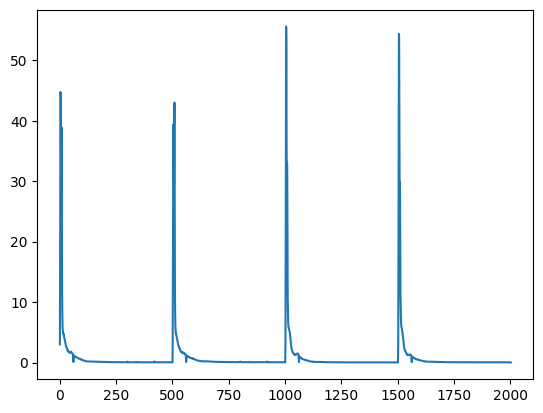

In [ ]:
df_final['pot'].plot()

<Axes: >

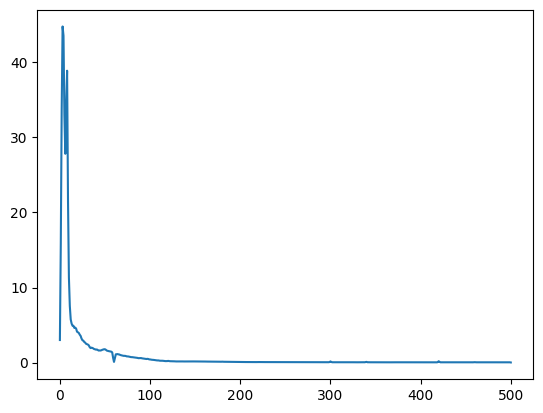

In [ ]:
df_final.iloc[0:501,1].plot()

In [ ]:
df_final.iloc[0] # iloc acessa indices numericos do df, o primeiro item são as LINHAS, o segundo são as COLUNAS

freq         0.0
pot     3.010361
cond     PRL_pre
Name: 0, dtype: object

In [ ]:
df_final.loc[:,'cond']

0       PRL_pre
1       PRL_pre
2       PRL_pre
3       PRL_pre
4       PRL_pre
         ...   
1999    CG1_pos
2000    CG1_pos
2001    CG1_pos
2002    CG1_pos
2003    CG1_pos
Name: cond, Length: 2004, dtype: object

In [ ]:
df['cond'] = 'PRL_pre' # com essa linha estou criando uma coluna em que a condicao se repete

## Como filtrar um DataFrame:

In [ ]:
(df_final['cond'] == 'PRL_pre').mean() # fazendo a media vc terá a proporcao desse elemento dentro do df

(df_final['cond'] == 'PRL_pre').sum() # ao somar vc conta quantos elementos correspondem a essa condicao

0.25

In [ ]:
df_final['cond'] == 'PRL_pre' #criando uma mascara booleana, ela servirá de índice para o seu df, o resultado vai mostrar só as condiçoes que estão dentro desse indice

0        True
1        True
2        True
3        True
4        True
        ...  
1999    False
2000    False
2001    False
2002    False
2003    False
Name: cond, Length: 2004, dtype: bool

In [ ]:
df_final[df_final['cond'] == 'PRL_pre'] # assim esta indexando o df com uma mascara booleana, ira resultar apenas nas partes que correspondem a condicao q esta dentro do []

,freq,pot,cond
0,0.0,3.010361,PRL_pre
1,1.0,15.904678,PRL_pre
2,2.0,33.778292,PRL_pre
3,3.0,44.764044,PRL_pre
4,4.0,43.529064,PRL_pre
...,...,...,...
496,496.0,0.043699,PRL_pre
497,497.0,0.042757,PRL_pre
498,498.0,0.043554,PRL_pre
499,499.0,0.041917,PRL_pre


In [ ]:
PSD_PRE = df_final.query(' (12 >= freq >= 4) and (cond == "PRL_pre") ') #esse query vc cria condiçoes que vai querer filtrar o df

4     43.529064
5     32.988175
6     27.808640
7     34.474304
8     38.871261
9     21.535313
10    11.335582
11     7.544558
12     5.747199
Name: pot, dtype: float64

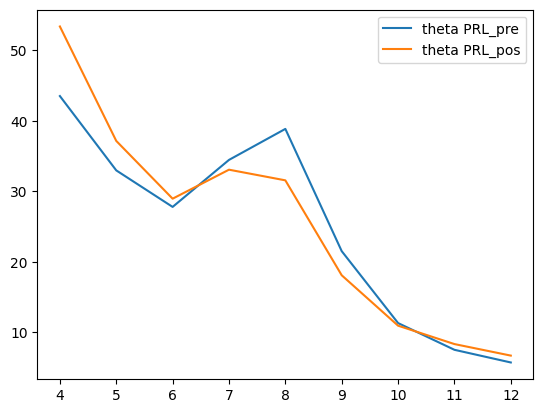

In [ ]:
plt.plot(df_final[ (df_final['freq'] >= 4) & (df_final['freq'] <= 12) & (df_final['cond'] == 'PRL_pre')]['freq'],df_final[ (df_final['freq'] >= 4) & (df_final['freq'] <= 12) & (df_final['cond'] == 'PRL_pre')]['pot'], label = 'theta PRL_pre')
plt.plot(df_final[ (df_final['freq'] >= 4) & (df_final['freq'] <= 12) & (df_final['cond'] == 'PRL_pos')]['freq'],df_final[ (df_final['freq'] >= 4) & (df_final['freq'] <= 12) & (df_final['cond'] == 'PRL_pos')]['pot'], label = 'theta PRL_pos')
plt.legend()

In [ ]:
df_final.grouby(['cond'], as_index = False)['pot'].agg({'mean_p':np.mean, 'SE':sp.stats.sem})

AttributeError: ignored

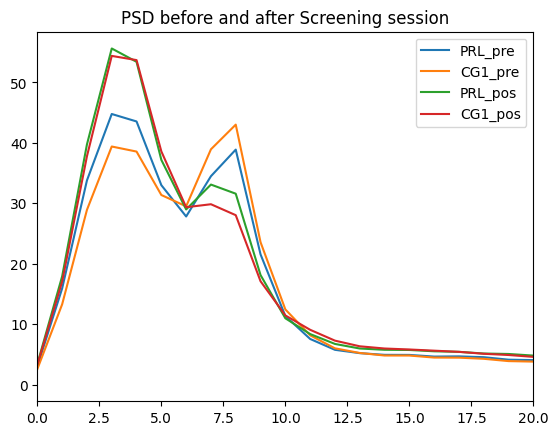

In [ ]:


for i in range(len(condicao)):
    key, value = list(condicao.items())[i]
    plt.plot(f, 10**(10*np.log10(potencia[i].transpose())/10), label = str(key))
    plt.xlim(0, 20)
plt.title('PSD before and after Screening session')
plt.legend()





  # for i in range(len(condicao)):
  #   for condicao in condicao:
  #     plt.plot(f, 10**(10*np.log10(potencia[i].transpose())/10) , label = condicao)
  #     plt.legend()
  #     plt.xlim(0,20)

In [ ]:
f, p = welch(PRL_pre, fs=1000, nperseg=1000, noverlap = 900)
p = p/np.mean(p)
sdmn_pre = sp.stats.sem(p)




plt.plot(f, 10**(10*np.log10(p.transpose())/10) , label='PSD pre-screening')



plt.xlim(0,20)
plt.title('PRL pré-screening')

In [ ]:
f, p = welch(PRL_pos, fs=1000, nperseg=1000, noverlap = 900)
p = p/np.mean(p)
sdmn_pre = sp.stats.sem(p)




plt.plot(f, 10**(10*np.log10(p.transpose())/10) , label='PSD pre-screening')



plt.xlim(0,20)
plt.title('PRL pos-screening')





In [ ]:
f, p = welch(CG1_pre, fs=1000, nperseg=1000, noverlap = 900)
p = p/np.mean(p)
sdmn_pre = sp.stats.sem(p)




plt.plot(f, 10**(10*np.log10(p.transpose())/10) , label='PSD pre-screening')



plt.xlim(0,20)
plt.title('CG1 pré-screening')


In [ ]:
f, p = welch(CG1_pos, fs=1000, nperseg=1000, noverlap = 900)
p = p/np.mean(p)
sdmn_pre = sp.stats.sem(p)




plt.plot(f, 10**(10*np.log10(p.transpose())/10) , label='PSD pre-screening')



plt.xlim(0,20)
plt.title('CG1 pos-screening')


In [ ]:
pip install statsmodels

before = media_pre
after = media_pos
statistic, p_value = wilcoxon(before, after)
# Print the test statistic and p-value
print("Wilcoxon signed-rank test statistic:", statistic)
print("P-value:", p_value)

> # TETRODO7: CH3

In [ ]:
f, p = welch(lista_filt_pre[2], fs=1000, nperseg=1000, noverlap = 900)
f2, p2 = welch(lista_filt_pos[2], fs=1000, nperseg=1000, noverlap = 900)

sdmn_dpre = sp.stats.sem(p)
sdmn_pos = sp.stats.sem(p2)

figura = plt.figure(figsize=(10,5))
figura.suptitle('PSD, OF pre e pós sessão de screening + 4*SD', fontweight ="bold")

figura.add_subplot(121)
plt.plot(f, p.transpose())
plt.fill_between(f,p.transpose(),  p.transpose() + 4*sdmn_dpre, color = 'lightblue')
plt.fill_between(f,p.transpose(),  p.transpose() - 4*sdmn_dpre, color = 'lightblue' )
plt.title('PSD OF pré-Screening', fontweight ="bold")
plt.xlim(0,20)

figura.add_subplot(122)
plt.plot(f2, p2.transpose())
plt.fill_between(f2,p2.transpose(),  p2.transpose() + 4*sdmn_dpre, color = 'lightblue')
plt.fill_between(f2,p2.transpose(),  p2.transpose() - 4*sdmn_dpre, color = 'lightblue' )
plt.title('PSD OF pós-Screening', fontweight ="bold")
plt.xlim(0,20)


In [ ]:
f, p = welch(lista_filt_pre[2], fs=1000, nperseg=1000, noverlap = 900)
f2, p2 = welch(lista_filt_pos[2], fs=1000, nperseg=1000, noverlap = 900)

sdmn_dpre = sp.stats.sem(p)
sdmn_pos = sp.stats.sem(p2)

figura = plt.figure(figsize=(10,5))
figura.suptitle('PSD normalizado, OF pre e pós sessão de screening', fontweight ="bold")

figura.add_subplot(121)
plt.plot(f, 10*np.log10(p.transpose()))
plt.title('PSD OF pré-Screening', fontweight ="bold")
plt.xlim(0,20)
plt.ylim(0,30)
figura.add_subplot(122)
plt.plot(f2, 10*np.log10(p2.transpose()))
plt.title('PSD OF pós-Screening', fontweight ="bold")
plt.xlim(0,20)
plt.ylim(0,30)

In [ ]:
print(len(lista_filt_pre[2]))

In [ ]:
pre = lista_filt_pre[2]
pos = lista_filt_pos[2]

sx = np.concatenate([pre, pos])

f, t, Sxx = spectrogram(sx, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
plt.pcolormesh(t, f, Sxx, cmap='turbo')
plt.ylim(0,30)
# plt.xlim(0,50)
plt.title( 'OF pré e pós sessão de screening ', fontweight ="bold" )
plt.axvline(x=92, color = 'white', linestyle = '--')
plt.xlabel('t(s)')
plt.ylabel('Frequências')
plt.colorbar()

In [ ]:
# FILTRANDO DELTA E THETA
window = signal.windows.hamming(1000)
filt_theta = firwin(300, [4,8], pass_zero='bandpass', window='hamming',  fs=1000)

media_theta_alltrials = (np.sum(lista_CS[2], axis=0))/30
theta = filtfilt(filt_theta, 1, media_theta_alltrials)

theta_pre = theta[0:2000]
theta_pos = theta[2000:4000]


f_pre, p_pre = welch(theta_pre, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_pre = sp.stats.sem(p_pre)


f_pos, p_pos = welch(theta_pos, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_pos = sp.stats.sem(p_pos)

In [ ]:
figura = plt.figure(figsize=(10,5))
figura.suptitle('THETA pré e pós screening, +- 4*SD', fontweight ="bold")

figura.add_subplot(121)
plt.plot(f_pre,p_pre.transpose(), linewidth=1, color='k')
plt.fill_between(f_pre,p_pre.transpose(),  p_pre.transpose() + 4*sdmn_pre, color = 'lightblue')
plt.fill_between(f_pre,p_pre.transpose(),  p_pre.transpose() - 4*sdmn_pre, color = 'lightblue' )
plt.title('Power de theta OF pré screening',fontweight ="bold")
plt.xlim(0,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

figura.add_subplot(122)
plt.plot(f_pos,p_pos.transpose(), linewidth=1, color='k')
plt.fill_between(f_pos,p_pos.transpose(),  p_pos.transpose() + 4*sdmn_pos , color = 'lightblue')
plt.fill_between(f_pos,p_pos.transpose(),  p_pos.transpose() - 4*sdmn_pos, color = 'lightblue' )
plt.title('Power de theta OF pós screening', fontweight ="bold")
plt.xlim(0,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')


In [ ]:
filt_delta = firwin(300, [0.1,4], pass_zero='bandpass', window='hamming',  fs=1000)

media_delta_alltrials = (np.sum(lista_CS[2], axis=0))/30
delta = filtfilt(filt_delta, 1, media_delta_alltrials)

delta_pre = delta[0:2000]
delta_pos = delta[2000:4000]

fd_pre, pd_pre = welch(delta_pre, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_dpre = sp.stats.sem(pd_pre)

fd_pos, pd_pos = welch(delta_pos, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_dpos = sp.stats.sem(pd_pos)

In [ ]:
figura = plt.figure(figsize=(10,5))
figura.suptitle('DELTA Média dos 30 trials, +- 4*SD', fontweight ="bold")

figura.add_subplot(121)
plt.plot(fd_pre,pd_pre.transpose(), linewidth=1, color='k')
plt.fill_between(fd_pre,pd_pre.transpose(),  pd_pre.transpose() + 4*sdmn_dpre, color = 'lightblue')
plt.fill_between(fd_pre,pd_pre.transpose(),  pd_pre.transpose() - 4*sdmn_dpre, color = 'lightblue' )
plt.title('Power de delta PRE-CS',fontweight ="bold")
plt.xlim(0,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

figura.add_subplot(122)
plt.plot(fd_pos,pd_pos.transpose(), linewidth=1, color='k')
plt.fill_between(fd_pos,pd_pos.transpose(),  pd_pos.transpose() + 4*sdmn_dpos , color = 'lightblue')
plt.fill_between(fd_pos,pd_pos.transpose(),  pd_pos.transpose() - 4*sdmn_dpos, color = 'lightblue' )
plt.title('Power de delta POS-CS', fontweight ="bold")
plt.xlim(0,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

* fazendo o PSD do trial 29, ele teve um espectrograma interessante

In [ ]:
theta = filtfilt(filt_theta, 1, lista_CS[2][28])

theta_pre = theta[0:2000]
theta_pos = theta[2000:4000]


f_pre, p_pre = welch(theta_pre, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_pre = sp.stats.sem(p_pre)


f_pos, p_pos = welch(theta_pos, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_pos = sp.stats.sem(p_pos)


In [ ]:
figura = plt.figure(figsize=(10,5))
figura.suptitle('THETA trial 29, +- 4*SD', fontweight ="bold")

figura.add_subplot(121)
plt.plot(f_pre,p_pre.transpose(), linewidth=1, color='k')
plt.fill_between(f_pre,p_pre.transpose(),  p_pre.transpose() + 4*sdmn_pre, color = 'lightblue')
plt.fill_between(f_pre,p_pre.transpose(),  p_pre.transpose() - 4*sdmn_pre, color = 'lightblue' )
plt.title('Power de theta PRE-CS',fontweight ="bold")
plt.xlim(2,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

figura.add_subplot(122)
plt.plot(f_pos,p_pos.transpose(), linewidth=1, color='k')
plt.fill_between(f_pos,p_pos.transpose(),  p_pos.transpose() + 4*sdmn_pos , color = 'lightblue')
plt.fill_between(f_pos,p_pos.transpose(),  p_pos.transpose() - 4*sdmn_pos, color = 'lightblue' )
plt.title('Power de theta POS-CS', fontweight ="bold")
plt.xlim(2,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')


* estou achando estranho pq o espectrograma não está mostrando esse power todo em 6HZ! ?????????

In [ ]:
filt_delta = firwin(300, [0.1,4], pass_zero='bandpass', window='hamming',  fs=1000)


delta = filtfilt(filt_delta, 1, lista_CS[2][28] )

delta_pre = delta[0:2000]
delta_pos = delta[2000:4000]

fd_pre, pd_pre = welch(delta_pre, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_dpre = sp.stats.sem(pd_pre)

fd_pos, pd_pos = welch(delta_pos, fs=1000, nperseg=1000, noverlap=int(0.9*1000))
sdmn_dpos = sp.stats.sem(pd_pos)

In [ ]:
figura = plt.figure(figsize=(10,5))
figura.suptitle('DELTA trial 29, +- 2*SD', fontweight ="bold")

figura.add_subplot(121)
plt.plot(fd_pre,pd_pre.transpose(), linewidth=1, color='k')
plt.fill_between(fd_pre,pd_pre.transpose(),  pd_pre.transpose() + 2*sdmn_dpre, color = 'lightblue')
plt.fill_between(fd_pre,pd_pre.transpose(),  pd_pre.transpose() - 2*sdmn_dpre, color = 'lightblue' )
plt.title('Power de delta PRE-CS',fontweight ="bold")
plt.xlim(0,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

figura.add_subplot(122)
plt.plot(fd_pos,pd_pos.transpose(), linewidth=1, color='k')
plt.fill_between(fd_pos,pd_pos.transpose(),  pd_pos.transpose() + 2*sdmn_dpos , color = 'lightblue')
plt.fill_between(fd_pos,pd_pos.transpose(),  pd_pos.transpose() - 2*sdmn_dpos, color = 'lightblue' )
plt.title('Power de delta POS-CS', fontweight ="bold")
plt.xlim(0,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

In [ ]:
figura = plt.figure(figsize=(10,5))
figura.suptitle('NORMALIZED THETA trial 29, +- 2*SD', fontweight ="bold")

figura.add_subplot(121)
plt.plot(f_pre,10*np.log10(p_pre.transpose()), linewidth=1, color='k')
plt.fill_between(f_pre,10*np.log10(p_pre.transpose()),  10*np.log10(p_pre.transpose()) + 2*sdmn_pre, color = 'lightblue')
plt.fill_between(f_pre,10*np.log10(p_pre.transpose()),  10*np.log10(p_pre.transpose()) - 2*sdmn_pre, color = 'lightblue' )
plt.title('Power de theta PRE-CS',fontweight ="bold")
plt.ylim(0,30)
plt.xlim(2,12)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

figura.add_subplot(122)
plt.plot(f_pos,10*np.log10(p_pos.transpose()), linewidth=1, color='k')
plt.fill_between(f_pos,10*np.log10(p_pos.transpose()), 10*np.log10(p_pos.transpose())+ 2*sdmn_pos , color = 'lightblue')
plt.fill_between(f_pos,10*np.log10(p_pos.transpose()), 10*np.log10(p_pos.transpose()) - 2*sdmn_pos, color = 'lightblue' )
plt.title('Power de theta POS-CS', fontweight ="bold")
plt.xlim(2,12)
plt.ylim(0,30)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

In [ ]:
figura = plt.figure(figsize=(10,5))
figura.suptitle('NORMALIZED DELTA trial 29, +- 2*SD', fontweight ="bold")

figura.add_subplot(121)
plt.plot(fd_pre,10*np.log10(pd_pre.transpose()), linewidth=1, color='k')
plt.fill_between(fd_pre,10*np.log10(pd_pre.transpose()), 10*np.log10(pd_pre.transpose()) + 2*sdmn_dpre, color = 'lightblue')
plt.fill_between(fd_pre,10*np.log10(pd_pre.transpose()), 10*np.log10(pd_pre.transpose()) - 2*sdmn_dpre, color = 'lightblue' )
plt.title('Power de delta PRE-CS',fontweight ="bold")
plt.xlim(0,12)
plt.ylim(0,30)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

figura.add_subplot(122)
plt.plot(fd_pos,10*np.log10(pd_pre.transpose()), linewidth=1, color='k')
plt.fill_between(fd_pos,10*np.log10(pd_pre.transpose()), 10*np.log10(pd_pre.transpose()) + 2*sdmn_dpos , color = 'lightblue')
plt.fill_between(fd_pos,10*np.log10(pd_pre.transpose()), 10*np.log10(pd_pre.transpose()) - 2*sdmn_dpos, color = 'lightblue' )
plt.title('Power de delta POS-CS', fontweight ="bold")
plt.xlim(0,12)
plt.ylim(0,30)
plt.xlabel('Frequencia (Hz)')
plt.ylabel('Power')

* AO NORMALIZAR, O DELTA PARECE ESTAR MUITO PARECIDO, NÃO ENTENDI ISSO TB!!!





> # US CUT

In [ ]:
lista_sinais = []
for i in range(32):
  lista_sinais.append(data[:,[i]])


#lista do valor máximo de cada canal

lista_mean_abs = []
for i in range(32):
  lista_mean_abs.append(np.max(np.abs(data[:,[i]])))

#definindo o threshold
threshold = (np.max(lista_mean_abs))/5


In [ ]:
shockTimestamp = np.zeros(914700)

idx_shock = np.array(lista_sinais[2][:])>=threshold
shockTimestamp[idx_shock[:,0]] = 1

plt.figure(figsize=(10,5))
plt.plot(shockTimestamp)
# plt.xlim(20000,22000)


In [ ]:
intervalos=[]
choque=0
registrando = 0
for i in range(0,len(shockTimestamp)):
  if (shockTimestamp[i]==0) and (shockTimestamp[i-1]==1):
    if(i+10000) < 913700:
      msmbarra = False
      for j in range(i,i+10000):
        if(shockTimestamp[j]==1):
          msmbarra=True
          break
      if msmbarra == False:
        choque=choque+1
        para_registrar=[]
        for k in range(i,i+4000):
          para_registrar.append(lista_sinais[2][k])
        intervalos.append(para_registrar)
    else:
      msmbarra = False
      for j in range(i,i+5000):
        if(shockTimestamp[j]==1):
          msmbarra=True
          break
      if msmbarra == False:
          choque=choque+1
          #print('queijo')
          para_registrar=[]
          for k in range(i,i+4000):
            #print(k)
            para_registrar.append(lista_sinais[2][k])
          intervalos.append(para_registrar)

In [ ]:
intervalos